In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import pandas as pd

In [22]:
df = pd.read_csv('data4.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,text,target
0,0,0,real good moment miss much,0
1,1,1,reading manga,0
2,2,2,NaN,0
3,3,3,need send em accountant tomorrow oddly even re...,0
4,4,4,add myspace myspace com lookthunder,0


In [29]:
df.dropna(inplace = True)

df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [30]:
df.head()

,text,target
0,real good moment miss much,0
1,reading manga,0
2,need send em accountant tomorrow oddly even re...,0
3,add myspace myspace com lookthunder,0
4,sleepy good time tonight though,0


<Axes: xlabel='target'>

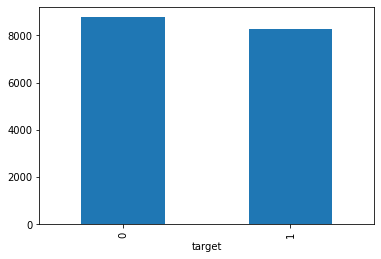

In [31]:
df.groupby(['target']).size().plot.bar()

In [32]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [33]:
# l = df['target'].to_list()
# print(l)
# type(l)

In [34]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = df['target'].to_list()
        self.texts = [tokenizer(str(text), 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [35]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

13631 1704 1704


In [36]:
df_train.columns

Index(['text', 'target'], dtype='object')

In [37]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [38]:
#training 

from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data) 

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 852/852 [18:43<00:00,  1.32s/it]


Epochs: 1 | Train Loss:  0.039                 | Train Accuracy:  0.814                 | Val Loss:  0.012                 | Val Accuracy:  0.954


100%|██████████| 852/852 [18:45<00:00,  1.32s/it]


Epochs: 2 | Train Loss:  0.008                 | Train Accuracy:  0.971                 | Val Loss:  0.008                 | Val Accuracy:  0.960


100%|██████████| 852/852 [18:45<00:00,  1.32s/it]


Epochs: 3 | Train Loss:  0.005                 | Train Accuracy:  0.981                 | Val Loss:  0.007                 | Val Accuracy:  0.968


100%|██████████| 852/852 [18:45<00:00,  1.32s/it]


Epochs: 4 | Train Loss:  0.003                 | Train Accuracy:  0.987                 | Val Loss:  0.007                 | Val Accuracy:  0.967


100%|██████████| 852/852 [18:45<00:00,  1.32s/it]


Epochs: 5 | Train Loss:  0.002                 | Train Accuracy:  0.992                 | Val Loss:  0.006                 | Val Accuracy:  0.972


In [ ]:
import pickle

In [ ]:
#load the pickle file
# with open('model.pickle', 'rb') as handle:
#     model = pickle.load(handle)

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return output
    
outputs = evaluate(model, df_test)

In [ ]:
outputs

tensor([[6.2041, 0.5328, 0.0000, 0.0000, 0.0000]], device='cuda:0')

In [ ]:
with open('model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)